In [1]:
import pandas as pd

import torch
import numpy as np
import random

# 乱数シードを固定
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load the Excel file, skipping the first 5 rows
file_path = '/Users/watanabeyuu/Documents/仮想環境1/env/eneos/20240627_フレア流量ENEOS追加データ/table/flare.xlsx'  # Update the path if necessary
df = pd.read_excel(file_path, skiprows=5)

# Extract the relevant columns
# Assuming that the date is in the first column, gas flow in the second column, and steam flow in the fourth column
date_column = df.columns[0]
gas_flow_column = df.columns[1]
steam_flow_column = df.columns[3]

# Create a new DataFrame with the extracted data
data = {
    'Date': df[date_column],
    'Gas Flow': df[gas_flow_column],
    'Steam Flow': df[steam_flow_column]
}
result_df = pd.DataFrame(data)
import os
def image_directory(directory_path,result_df):
    # ディレクトリ内のすべてのサブディレクトリを取得
    for subdir, _, files in os.walk(directory_path):
        for filename in files:
            if filename.lower().endswith('.jpg'):
                file_path = os.path.join(subdir, filename)
                # 画像名から日付と時間を抽出
                image_name = os.path.basename(file_path)
                date_str = image_name.split('.')[0]
                date_formatted = f"{date_str[:4]}-{date_str[5:7]}-{date_str[7:9]} {date_str[10:12]}:{date_str[12:14]}:{date_str[14:16]}"
                # 対応する行を特定
                result_df.loc[result_df['Date'] == date_formatted, 'path'] = file_path
image_directory('/Users/watanabeyuu/Documents/仮想環境1/env/eneos/20240627_フレア流量ENEOS追加データ/image',result_df)
# 'area' が None ではない行をフィルタリング
non_none_df = result_df[result_df['path'].notna()]


# 2024年3月1日以降のデータのみを抽出
start_date = '2024-03-01'
df = non_none_df[non_none_df['Date'] >= start_date]
df['Steam Flow Series'] = [None] * len(df)  # Noneで初期化
for i in range(len(df)):
    current_idx = df.index[i]
    date_current=result_df.loc[current_idx, 'Date']
    date_previous=result_df.loc[current_idx-9, 'Date']
    # 両者の時間差を計算
    time_difference = (date_current - date_previous).total_seconds() / 60  # 分単位での差
    # 10分差かどうか確認
    if abs(time_difference) == 9.0:
        previous_10_indices = result_df.index[current_idx-9:current_idx+1]  # 前10行のインデックスを取得
        previous_10_steam_flows = result_df.loc[previous_10_indices, 'Steam Flow']  # 前10行のスチーム流量を取得
        #print(previous_10_steam_flows.tolist())
        df.at[current_idx, 'Steam Flow Series']=previous_10_steam_flows.tolist() # リストに変換して保存

# セル内の最大表示文字数を制限しない
pd.set_option('display.max_colwidth', None)
# インデックスをリセットし、新たに idx を振り直す
df = df.reset_index(drop=True)

# フィルタリングされたデータフレームを表示
print(df)
# 2023年11月30日までのデータのみを抽出
end_date = '2023-12-01'
df2 = non_none_df[non_none_df['Date'] <= end_date]
df2['Steam Flow Series'] = [None] * len(df2)  # Noneで初期化
for i in range(len(df2)):
    current_idx = df2.index[i]
    date_current=result_df.loc[current_idx, 'Date']
    date_previous=result_df.loc[current_idx-9, 'Date']
    # 両者の時間差を計算
    time_difference = (date_current - date_previous).total_seconds() / 60  # 分単位での差
    # 10分差かどうか確認
    if abs(time_difference) == 9.0:
        previous_10_indices = result_df.index[current_idx-9:current_idx+1]  # 前10行のインデックスを取得
        previous_10_steam_flows = result_df.loc[previous_10_indices, 'Steam Flow']  # 前10行のスチーム流量を取得
        #print(previous_10_steam_flows.tolist())
        df2.at[current_idx, 'Steam Flow Series']=previous_10_steam_flows.tolist() # リストに変換して保存

# インデックスをリセットし、新たに idx を振り直す
df2 = df2.reset_index(drop=True)

# フィルタリングされたデータフレームを表示
print(df2)
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


class GasFlowDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df['path'].iloc[idx]
        image = Image.open(image_path).convert('RGB')  # RGBに変換

        if self.transform:
            image = self.transform(image)
        
        # スチーム流量とガス流量を取得
        steam_flow_series = torch.tensor(self.df['Steam Flow Series'].iloc[idx], dtype=torch.float32)
        gas_flow = torch.tensor(self.df['Gas Flow'].iloc[idx], dtype=torch.float32)

        return image, steam_flow_series, gas_flow, idx

# カスタム変換: 画像の右半分を切り取る
class RightHalfCrop:
    def __call__(self, img):
        width, height = img.size
        left = width // 2  # 右半分を開始する位置
        return img.crop((left, 0, width, height))

transform = transforms.Compose([
    RightHalfCrop(),
    transforms.Resize(128),                 # 短辺を128にリサイズ
    transforms.CenterCrop((128, 128)),      # 128x128の中心クロップ
    transforms.ToTensor(),                  # Tensorに変換
    ])

import torch.nn as nn
import torch.nn.functional as F



class SimpleMultiModalNN(nn.Module):
    def __init__(self):
        super(SimpleMultiModalNN, self).__init__()
        
        # スチーム流量処理部分（LSTM）
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=2, batch_first=True)
        
        # 最終予測層
        self.fc = nn.Linear(256, 1)  # LSTMの隠れ状態サイズから1つの出力への全結合層

    def forward(self, steam_flow_series):
        # スチーム流量処理部分（LSTM）
        steam_flow_series = steam_flow_series.unsqueeze(-1)  # Batch_size x Seq_len x 1 (1はスチーム流量の特徴量数)
        lstm_out, (hn, cn) = self.lstm(steam_flow_series)  # LSTMを通過
        steam_flow_features = hn[-1]  # LSTMの最終的な隠れ状態を使用（Batch_size x hidden_size）
        
        # 最終予測層
        x = self.fc(steam_flow_features)
        return x


/var/folders/5_/fd702ty56x79nfv6cjkcb2y80000gn/T/ipykernel_16851/929641017.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Steam Flow Series'] = [None] * len(df)  # Noneで初期化


                     Date  Gas Flow  Steam Flow  \
0     2024-03-01 00:00:00  0.218240   13.546737   
1     2024-03-01 00:10:00  0.220848   13.503280   
2     2024-03-01 00:20:00  0.219022   13.534142   
3     2024-03-01 00:30:00  0.220575   13.474668   
4     2024-03-01 00:40:00  0.218634   13.451664   
...                   ...       ...         ...   
10363 2024-06-10 23:10:00  0.257464   12.984609   
10364 2024-06-10 23:20:00  0.253228   12.945408   
10365 2024-06-10 23:30:00  0.261182   13.013731   
10366 2024-06-10 23:40:00  0.252889   12.987830   
10367 2024-06-10 23:50:00  0.260434   12.962210   

                                                                                                            path  \
0      /Users/watanabeyuu/Documents/仮想環境1/env/eneos/20240627_フレア流量ENEOS追加データ/image/20240301/2024_0301_000000.jpg   
1      /Users/watanabeyuu/Documents/仮想環境1/env/eneos/20240627_フレア流量ENEOS追加データ/image/20240301/2024_0301_001000.jpg   
2      /Users/watanabeyuu/Documents/仮想環

/var/folders/5_/fd702ty56x79nfv6cjkcb2y80000gn/T/ipykernel_16851/929641017.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Steam Flow Series'] = [None] * len(df2)  # Noneで初期化


                    Date  Gas Flow  Steam Flow  \
0    2023-10-25 15:00:00  0.297466    5.115461   
1    2023-10-25 15:10:00  0.298861    5.006025   
2    2023-10-25 15:20:00  0.295851    4.835564   
3    2023-10-25 15:30:00  0.297528    5.010692   
4    2023-10-25 15:40:00  0.291443    5.127869   
...                  ...       ...         ...   
5230 2023-11-30 23:10:00  0.239181   12.226214   
5231 2023-11-30 23:20:00  0.235349   12.249908   
5232 2023-11-30 23:30:00  0.235787   12.285759   
5233 2023-11-30 23:40:00  0.235101   12.309461   
5234 2023-11-30 23:50:00  0.237540   12.227715   

                                                                                                           path  \
0     /Users/watanabeyuu/Documents/仮想環境1/env/eneos/20240627_フレア流量ENEOS追加データ/image/20231025/2023_1025_150000.jpg   
1     /Users/watanabeyuu/Documents/仮想環境1/env/eneos/20240627_フレア流量ENEOS追加データ/image/20231025/2023_1025_151000.jpg   
2     /Users/watanabeyuu/Documents/仮想環境1/env/eneos/202

Mean Squared Error on training data: 4.315868017200999


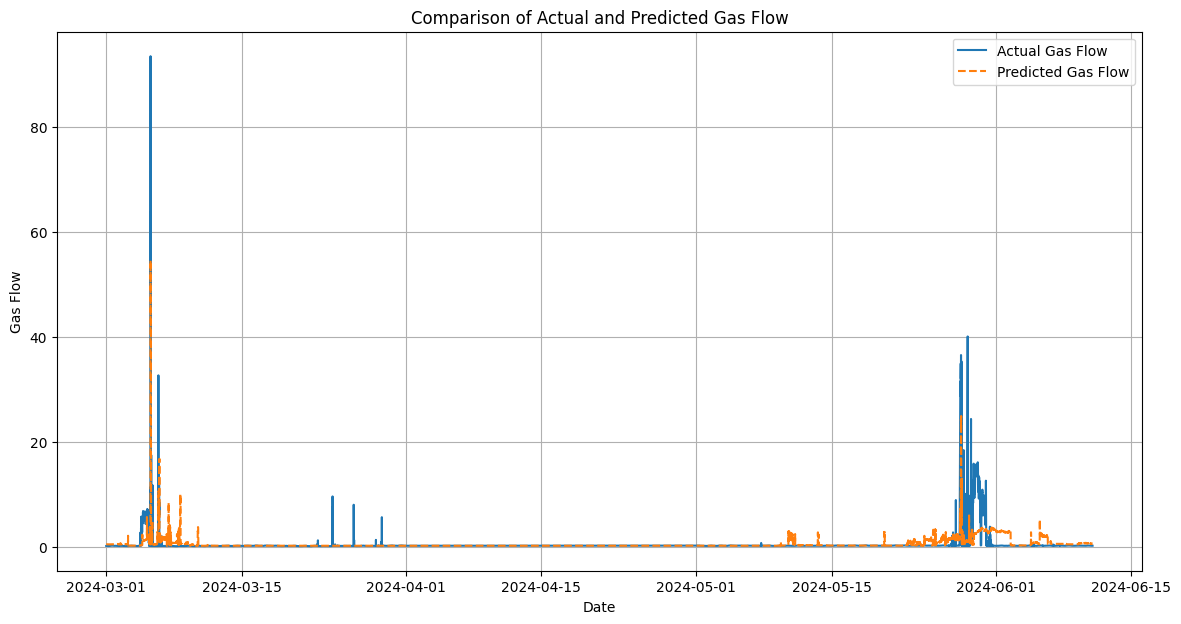

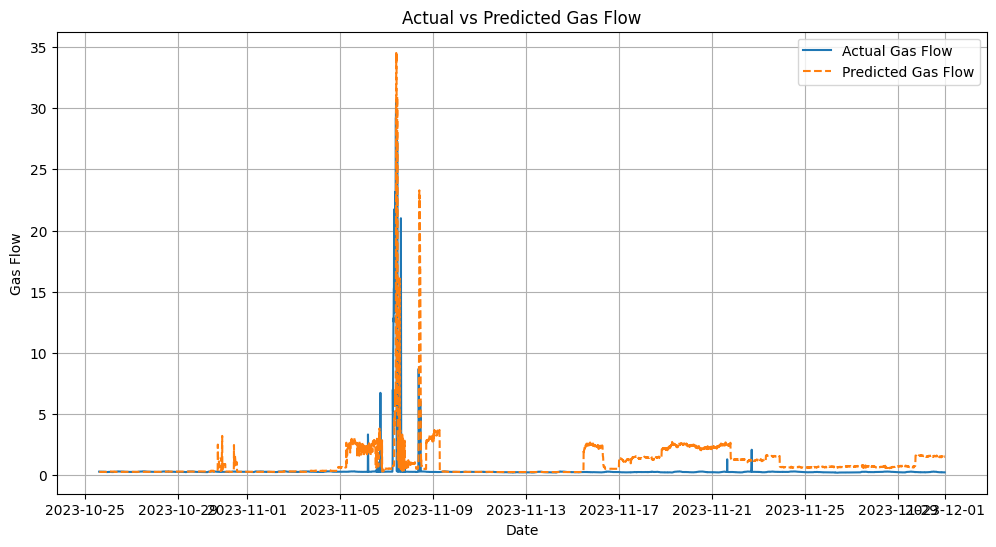

Mean Squared Error on new data: 2.5019543763083445


In [2]:
from sklearn.metrics import mean_squared_error
import torch.optim as optim

dataset = GasFlowDataset(df=df, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


    
# モデルの初期化
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleMultiModalNN().to(device)
criterion =nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# モデルの訓練
for epoch in range(50):  # エポック数は調整が必要
    model.train()
    for inputs, steam_flow_series, gas_flow, _ in data_loader:  # gas_flow を追加
        inputs, steam_flow_series, gas_flow  = inputs.to(device), steam_flow_series.to(device), gas_flow.to(device)
        optimizer.zero_grad()
        outputs = model(steam_flow_series)
        loss = criterion(outputs.squeeze(), gas_flow)  # gas_flow を直接使用
        loss.backward()
        optimizer.step()

# モデルの評価
model.eval()
predictions = [None]*len(dataset.df)
actuals = [None]*len(dataset.df)
with torch.no_grad():
    for inputs, steam_flow_series, gas_flow ,idx in data_loader:  # gas_flow を追加
        inputs, steam_flow_series = inputs.to(device), steam_flow_series.to(device)
        outputs = model(steam_flow_series)
        for i in range(len(idx)):#len(idx)はバッチサイズ
            index=idx[i].item()#整数に変換
            predictions[index]=outputs[i].cpu().numpy()
            actuals[index]=gas_flow[i].cpu().numpy()

dataset.df['prediction'] = predictions
# 訓練データに対するMSEを計算
mse_train = mean_squared_error(df['Gas Flow'], np.array(predictions))
print(f"Mean Squared Error on training data: {mse_train}")

# 訓練データの予測結果を保存
dataset.df['prediction'] = predictions

dates = dataset.df['Date']

import matplotlib.pyplot as plt
# グラフの作成
plt.figure(figsize=(14, 7))
plt.plot(dates, dataset.df['Gas Flow'], label='Actual Gas Flow')
plt.plot(dates, dataset.df['prediction'], label='Predicted Gas Flow', linestyle='--')

# グラフの装飾
plt.xlabel('Date')
plt.ylabel('Gas Flow')
plt.title('Comparison of Actual and Predicted Gas Flow')
plt.legend()
plt.grid(True)

plt.show()

# df2のデータでの検証
dataset2 = GasFlowDataset(df=df2, transform=transform)
data_loader2 = DataLoader(dataset2, batch_size=32, shuffle=False)

# df2に対して予測を実施
predictions_df2 = []
with torch.no_grad():
    model.eval()
    for inputs, steam_flow_series, _ ,_ in data_loader2:
        inputs, steam_flow_series = inputs.to(device), steam_flow_series.to(device)
        outputs = model(steam_flow_series)
        predictions_df2.extend(outputs.cpu().numpy())

# df2に予測結果を追加
df2['prediction'] = predictions_df2

# 結果の表示
plt.figure(figsize=(12, 6))
plt.plot(df2['Date'], df2['Gas Flow'], label='Actual Gas Flow')
plt.plot(df2['Date'], df2['prediction'], label='Predicted Gas Flow', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Gas Flow')
plt.title('Actual vs Predicted Gas Flow')
plt.legend()
plt.grid(True)

plt.show()

# スコアの計算
mse_new = mean_squared_error(df2['Gas Flow'], df2['prediction'])
print(f"Mean Squared Error on new data: {mse_new}")

In [3]:
df_data=df2.drop(columns='path')
df_data['prediction']=df_data['prediction'].apply(lambda x: x[0])
df_data.to_excel('/Users/watanabeyuu/Documents/仮想環境1/env/eneos/results/datatime1.xlsx')